In [1]:
# --- 1️⃣ Import Libraries ---
import pandas as pd
import snowflake.connector
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

In [ ]:
# --- Connect to Snowflake ---
conn = snowflake.connector.connect(
    user='your_username',
    password='your_password',
    account='your_account',   # e.g., abcd1234.us-east-1
    warehouse='MY_WH',
    database='CHATGPT_DB',
    schema='CHATGPT_SCHEMA'
)

In [ ]:
print("✅ Connected to Snowflake successfully!")
conn.close()

In [3]:
file_path = "chatgpt_cleaned.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

,Category,Subcategory,Item,Date,Value,Notes
0,Version,Release,GPT-3.5 (ChatGPT initial),30-Nov-22,Initial chat model,Instruction-tuned; 1M users in 5 days
1,Version,Release,GPT-4,14-Mar-23,Multimodal (text+images),Introduced paid Plus tier
2,Version,Release,GPT-4 Turbo,6-Nov-23,"Faster, cheaper; 128K context",Optimized for long conversations
3,Version,Release,GPT-4o,13-May-24,"Omni model: real-time voice, vision",Native multimodal; free tier access
4,Version,Release,GPT-4.5,Feb-25,Preview 'Orion' enhancements,Improved reasoning


In [ ]:
# --- 3️⃣ Initial Inspection ---
print("Data Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

Data Shape: (55, 6)
Columns: ['Category', 'Subcategory', 'Item', 'Date', 'Value', 'Notes']
  Category Subcategory                       Item               Date  \
0  Version     Release  GPT-3.5 (ChatGPT initial)  November 30, 2022   
1  Version     Release                      GPT-4     March 14, 2023   
2  Version     Release                GPT-4 Turbo   November 6, 2023   
3  Version     Release                     GPT-4o       May 13, 2024   
4  Version     Release                    GPT-4.5      February 2025   

                                 Value                                  Notes  
0                   Initial chat model  Instruction-tuned; 1M users in 5 days  
1             Multimodal (text+images)              Introduced paid Plus tier  
2        Faster, cheaper; 128K context       Optimized for long conversations  
3  Omni model: real-time voice, vision    Native multimodal; free tier access  
4         Preview 'Orion' enhancements                     Improved reasonin

In [ ]:
# --- 4️⃣ Convert Date column ---
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


In [ ]:
# --- 5️⃣ Clean and Convert 'Value' column ---
def extract_numeric(val):
    if pd.isna(val):
        return np.nan
    val = str(val)
    # Remove $, commas, % etc.
    val = val.replace(",", "").replace("$", "").replace("%", "")
    # Extract first numeric pattern
    import re
    match = re.search(r"[-+]?\d*\.?\d+", val)
    return float(match.group()) if match else np.nan

df["Value_numeric"] = df["Value"].apply(extract_numeric)

print("\nConverted numeric values count:", df["Value_numeric"].notna().sum())


Converted numeric values count: 49


In [ ]:
# --- 6️⃣ Handle Missing Data ---
df["Notes"].fillna("No notes", inplace=True)

/tmp/ipython-input-953494501.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
# --- 7️⃣ Basic Summary ---
print("\nSummary Stats (numeric values):")
print(df["Value_numeric"].describe())

category_summary = df.groupby("Category")["Value_numeric"].agg(["count", "sum", "mean"]).reset_index()
subcategory_summary = df.groupby("Subcategory")["Value_numeric"].agg(["count", "sum", "mean"]).reset_index()
item_summary = df.groupby("Item")["Value_numeric"].sum().sort_values(ascending=False).reset_index()



Summary Stats (numeric values):
count     49.000000
mean      97.733102
std      167.915505
min        0.002000
25%       10.000000
50%       45.000000
75%       89.400000
max      800.000000
Name: Value_numeric, dtype: float64


In [ ]:
# --- 8️⃣ Save Cleaned Data ---
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)
df.to_csv(output_dir / "chatgpt_cleaned_value_converted_full.csv", index=False)

In [ ]:
# --- 9️⃣ Static Visualizations (Matplotlib / Seaborn) ---
sns.set(style="whitegrid", palette="pastel")

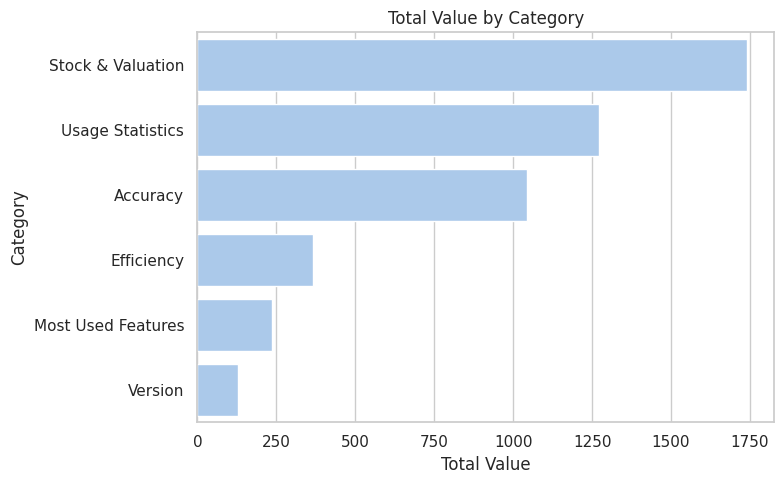

In [ ]:
# Plot 1: Category Breakdown
plt.figure(figsize=(8,5))
sns.barplot(data=category_summary.sort_values("sum", ascending=False),
            x="sum", y="Category")
plt.title("Total Value by Category")
plt.xlabel("Total Value")
plt.ylabel("Category")
plt.tight_layout()
plt.savefig(output_dir / "category_value.png")
plt.show()

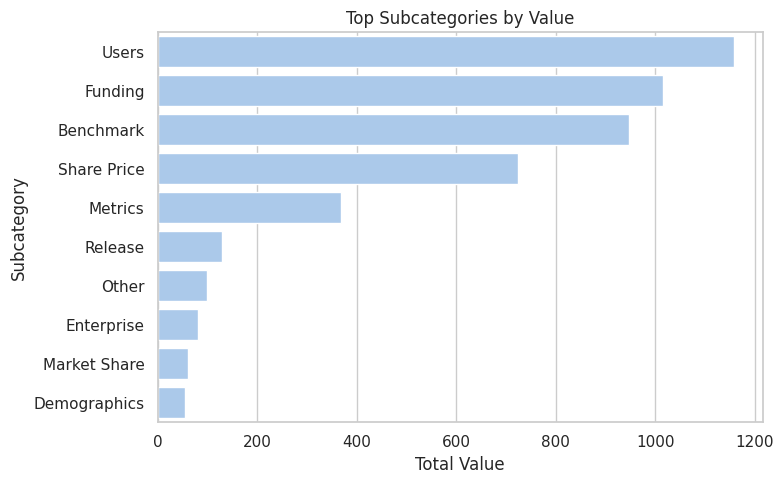

In [ ]:
# Plot 2: Top Subcategories
top_subcat = subcategory_summary.sort_values("sum", ascending=False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(data=top_subcat, x="sum", y="Subcategory")
plt.title("Top Subcategories by Value")
plt.xlabel("Total Value")
plt.ylabel("Subcategory")
plt.tight_layout()
plt.savefig(output_dir / "top_subcategories.png")
plt.show()

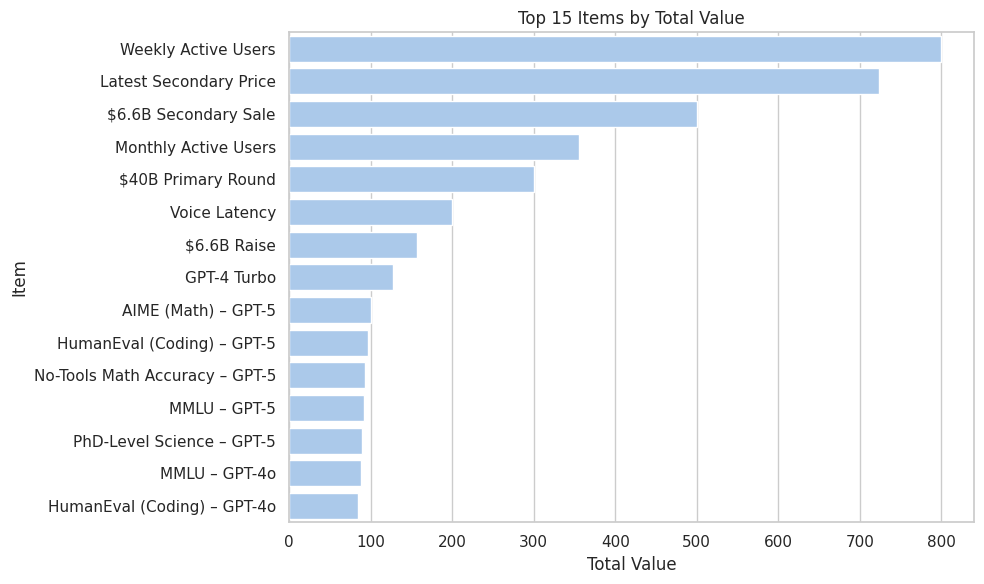

In [ ]:
# Plot 3: Top 15 Items
plt.figure(figsize=(10,6))
sns.barplot(data=item_summary.head(15), x="Value_numeric", y="Item")
plt.title("Top 15 Items by Total Value")
plt.xlabel("Total Value")
plt.ylabel("Item")
plt.tight_layout()
plt.savefig(output_dir / "top_items.png")
plt.show()

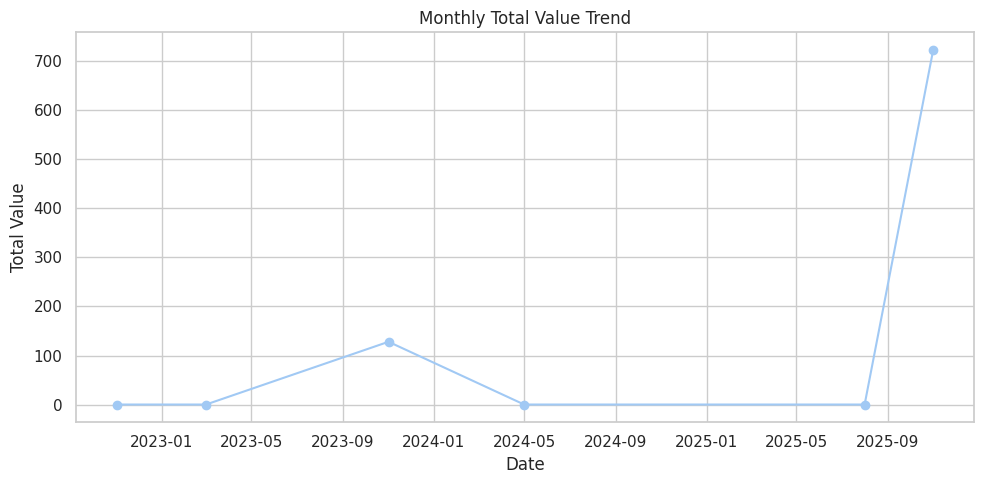

In [ ]:
# Plot 4: Time-Series Trend
if df["Date"].notna().sum() > 0:
    monthly = df.groupby(df["Date"].dt.to_period("M"))["Value_numeric"].sum().reset_index()
    monthly["Date"] = monthly["Date"].dt.to_timestamp()
    plt.figure(figsize=(10,5))
    plt.plot(monthly["Date"], monthly["Value_numeric"], marker="o")
    plt.title("Monthly Total Value Trend")
    plt.xlabel("Date")
    plt.ylabel("Total Value")
    plt.tight_layout()
    plt.savefig(output_dir / "monthly_value.png")
    plt.show()


In [ ]:
# --- 🔟 Interactive Dashboard (Plotly) ---
fig_cat = px.bar(category_summary, x="Category", y="sum",
                 title="Total Value by Category", color="Category")

fig_sub = px.bar(top_subcat, x="Subcategory", y="sum",
                 title="Top Subcategories by Value", color="Subcategory")

fig_items = px.bar(item_summary.head(15), x="Item", y="Value_numeric",
                   title="Top 15 Items by Value", color="Item")

if df["Date"].notna().sum() > 0:
    fig_time = px.line(monthly, x="Date", y="Value_numeric",
                       title="Monthly Value Trend", markers=True)
else:
    fig_time = go.Figure()

In [ ]:
# Combine dashboards into HTML
from plotly.subplots import make_subplots
from plotly.offline import plot

dashboard = make_subplots(rows=2, cols=2, subplot_titles=(
    "Category Breakdown", "Top Subcategories", "Top Items", "Monthly Trend"))

for trace in fig_cat.data:
    dashboard.add_trace(trace, row=1, col=1)
for trace in fig_sub.data:
    dashboard.add_trace(trace, row=1, col=2)
for trace in fig_items.data:
    dashboard.add_trace(trace, row=2, col=1)
for trace in fig_time.data:
    dashboard.add_trace(trace, row=2, col=2)

dashboard.update_layout(height=900, width=1300, title_text="ChatGPT Usage & Feature Analysis Dashboard")
plot(dashboard, filename=str(output_dir / "interactive_dashboard.html"), auto_open=False)

print("\n✅ Analysis complete! Files saved in 'outputs/' folder:")
print(" - Cleaned CSV: chatgpt_cleaned_value_converted_full.csv")
print(" - Static plots: category_value.png, top_subcategories.png, top_items.png, monthly_value.png")
print(" - Interactive dashboard: interactive_dashboard.html")


✅ Analysis complete! Files saved in 'outputs/' folder:
 - Cleaned CSV: chatgpt_cleaned_value_converted_full.csv
 - Static plots: category_value.png, top_subcategories.png, top_items.png, monthly_value.png
 - Interactive dashboard: interactive_dashboard.html
